This notebook creates the table of RTC data covering a subset of the DIST-HLS validation sites over 2022-2023 (see the previous directory of notebooks for how this subset was generated).

In [1]:
import concurrent.futures
import urllib3
from tqdm import tqdm
import pandas as pd
import geopandas as gpd
from dem_stitcher.geojson_io import read_geojson_gzip, to_geojson_gzip
from shapely.geometry import Polygon
import rasterio
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import numpy as np
from shapely.geometry import shape
import rasterio.features as features
from mpire import WorkerPool

# Read the tables

In [2]:
df_rtc = pd.read_json('rtc_s1_table.json.zip')
df_rtc.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
1,OPERA_L2_RTC-S1_T005-008688-IW2_20201022T00400...,S1A_IW_SLC__1SDV_20201022T004000_20201022T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-22 00:40:00
2,OPERA_L2_RTC-S1_T005-008688-IW2_20201103T00400...,S1A_IW_SLC__1SDV_20201103T004000_20201103T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-03 00:40:00
3,OPERA_L2_RTC-S1_T005-008688-IW2_20201115T00400...,S1A_IW_SLC__1SDV_20201115T004000_20201115T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-15 00:40:00
4,OPERA_L2_RTC-S1_T005-008688-IW2_20201127T00400...,S1A_IW_SLC__1SDV_20201127T004000_20201127T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-11-27 00:40:00


In [3]:
df_rtc_per_burst = df_rtc.groupby('jpl_burst_id').size().reset_index(name='count')
df_rtc_per_burst.head()

,jpl_burst_id,count
0,T005-008688-IW2,66
1,T005-008688-IW3,66
2,T005-008689-IW1,66
3,T005-008689-IW2,66
4,T005-008689-IW3,66


In [4]:
df_val_burst_old= read_geojson_gzip('../4_rtc_organization/burst_extent_subset.geojson.gzip')#validation_bursts_all_v2.parquet')
df_val_burst_old.head()

,geometry,jpl_burst_id,orbit_pass
0,"POLYGON ((-97.90103 16.86358, -97.06559 17.014...",t005_008688_iw2,ASCENDING
1,"POLYGON ((-97.09889 17.06678, -96.35902 17.196...",t005_008688_iw3,ASCENDING
2,"POLYGON ((-98.69436 16.82087, -97.89903 16.966...",t005_008689_iw1,ASCENDING
3,"POLYGON ((-97.93486 17.03023, -97.09864 17.180...",t005_008689_iw2,ASCENDING
4,"POLYGON ((-97.13196 17.23328, -96.39139 17.362...",t005_008689_iw3,ASCENDING


In [7]:
df_val_burst=gpd.read_parquet('../3_dist_sites/validation_bursts_all_v1.parquet')
df_val_burst.head()


,jpl_burst_id,site_id,orbit_pass,track_number,geometry
0,T090-193169-IW1,1,ASCENDING,90,"POLYGON ((-52.73133 -23.43816, -51.90414 -23.2..."
1,T097-207419-IW2,1,DESCENDING,97,"POLYGON ((-51.66339 -23.30842, -52.52125 -23.1..."
2,T039-083584-IW3,2,ASCENDING,39,"POLYGON ((129.8254 -29.63759, 130.62076 -29.44..."
3,T075-160202-IW1,2,DESCENDING,75,"POLYGON ((130.4964 -29.60892, 129.63063 -29.40..."
4,T107-227877-IW2,3,ASCENDING,107,"POLYGON ((-99.31968 33.56634, -98.35539 33.705..."


In [8]:
df_site = gpd.read_file('../3_dist_sites/dist_hls_val_sites.geojson')
df_site.head()

,site_id,change_label,change_type,change_time,last_observation_time,mgrs_tile_id,geometry
0,1,VLmaj,Natural browning,2021-10-08,NaT,22KCV,POINT (-52.37979 -23.29715)
1,2,noChange,No Change,NaT,NaT,52JEN,POINT (129.85033 -29.57724)
2,3,VLmin,Natural browning,2022-01-28,2022-01-06,14SNC,POINT (-98.60056 33.771)
3,4,VLmaj,Fire,2021-11-07,2021-11-02,34NCL,POINT (19.33289 4.5749)
4,5,VLmaj,Fire,2022-05-18,2022-05-11,50VMR,POINT (115.61901 63.10809)


# Get Actual Coverage

In [9]:
df_rtc_first = df_rtc.groupby(['jpl_burst_id']).head(1)
df_rtc_first.head()

,rtc_s1_id,input_slc_id,jpl_burst_id,bursts_per_slc_input,rtc_s1_vv_url,rtc_s1_vh_url,rtc_s1_h5_url,acq_datetime
0,OPERA_L2_RTC-S1_T005-008688-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
66,OPERA_L2_RTC-S1_T005-008688-IW3_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008688-IW3,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
132,OPERA_L2_RTC-S1_T005-008689-IW1_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008689-IW1,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
198,OPERA_L2_RTC-S1_T005-008689-IW2_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008689-IW2,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01
264,OPERA_L2_RTC-S1_T005-008689-IW3_20201010T00400...,S1A_IW_SLC__1SDV_20201010T004001_20201010T0040...,T005-008689-IW3,27,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,https://opera-pst-rs-pop1.s3.us-west-2.amazona...,2020-10-10 00:40:01


In [10]:
def get_coverage_geo(url: str) -> Polygon:
    with rasterio.open(url) as ds:
        mask = ds.read_masks(1).astype(np.uint8)
        transform = ds.transform
        crs = ds.crs
    t = nd.binary_dilation(mask, iterations=6)
    mask = nd.binary_erosion(t, iterations=6).astype(np.uint8)
    # fill in small nodata
    mask = nd.binary_dilation(mask, iterations=6)
    mask = nd.binary_erosion(mask, iterations=6).astype(np.uint8)

    # Get features as geometric shape
    polys = list(features.shapes(1-mask, mask=(mask.astype(bool)), transform=transform))
    geo = shape(polys[0][0])
    return geo, crs

geo_cov, crs = get_coverage_geo(df_rtc_first.rtc_s1_vh_url.tolist()[5])
geo_cov, crs

(<POLYGON ((612780 1916070, 612780 1916040, 612630 1916040, 612630 1916010, 6...>,
 CRS.from_epsg(32614))

In [12]:
with WorkerPool(n_jobs=15, use_dill=True) as pool:
    data = pool.map(
        get_coverage_geo, df_rtc_first.rtc_s1_vh_url.tolist(), progress_bar=True, progress_bar_style='notebook'
    )

  0%|                                        | 0/3429 [00:00<?, ?it/s]

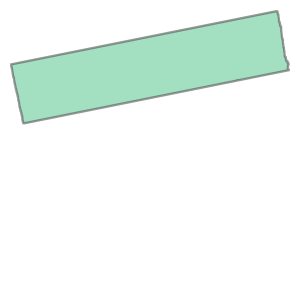

In [13]:
data[0][0]

In [14]:
def transform_geo_to_4326(geo: Polygon, src_utm):
    wgs84 = CRS.from_epsg(4326)
    #geo, src_utm = input_data

    project = pyproj.Transformer.from_crs(src_utm, wgs84, always_xy=True).transform
    geo_4326 = transform(project, geo)
    return geo_4326

transform_geo_to_4326(*data[0])

NameError: name 'CRS' is not defined

In [ ]:
with WorkerPool(n_jobs=15, use_dill=True) as pool:
    geometry_4326_updated = pool.map(
        transform_geo_to_4326, (d for d in data), progress_bar=True, progress_bar_style='notebook', iterable_len=len(data)
    )

In [ ]:
df_burst_cov = gpd.GeoDataFrame(df_rtc_first[['jpl_burst_id']] , geometry=geometry_4326_updated, crs=CRS.from_epsg(4326))
df_burst_cov = pd.merge(df_burst_cov, df_rtc_per_burst, on='jpl_burst_id', how='inner')
df_burst_cov = df_burst_cov.rename(columns={'count': 'n_acquisitions'})
df_burst_cov.head()

In [ ]:
# fig, ax= plt.subplots(figsize=(15, 5))
# df_burst_cov.plot(ax=ax)
# df_val_burst.plot(ax=ax, color='yellow')
# ax.set_ylim(40, 60)
# ax.set_xlim(0, 50)

# Spatial Join of Sites and bursts

In [ ]:
df_bursts_covering_sites = gpd.sjoin(df_burst_cov, df_site[['site_id', 'geometry']], predicate='intersects', how='inner').reset_index(drop=True)
df_bursts_covering_sites.drop(columns='index_right', inplace=True)
df_bursts_covering_sites.head()

In [ ]:
df_bursts_covering_sites.n_acquisitions.unique()

In [ ]:
df_bursts_covering_sites = df_bursts_covering_sites[df_bursts_covering_sites.n_acquisitions > 30].reset_index(drop=True)

In [ ]:
bursts_in_val_and_cov = [b_id for b_id in df_val_burst.jpl_burst_id.tolist() if b_id in df_bursts_covering_sites.jpl_burst_id.tolist()]
len(bursts_in_val_and_cov)

In [ ]:
df_bursts_covering_sites.to_parquet('validation_bursts_v1_coverage_updated.parquet')